[A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576)

Code here follows the [TensorFlow](https://www.tensorflow.org/) implementation by Mark Chang found [here](https://github.com/ckmarkoh/neuralart_tensorflow).

**NOTE**: this notebook was tested with Python 3, but it _should_ also work with Python 2 as long as you have TensorFlow, six, and other required libraries. It hasn't been test with Python 2, so if there are problems, open a pull request or file an issue, etc.

## Introduction

Let's explore artistic style transfer. Why?

* Sort of a cool demonstration.
* From a physics perspective, I wondered if it were possible to understand simulation tuning by looking at event style (spoiler alert - no).
* It turns out to be very simple, technically - so we get a chance to see some of the machinery of a deep learning library work without needing a huge variety of functions from the library, etc.

We will use a pre-trained convolutional network built for object classification (in this case, the [2014 ImageNet competition](http://www.image-net.org/challenges/LSVRC/2014/results#clsloc)) and we will study activations in the model weights. Rather than varying the weights to achieve a task, we're actually going to vary the _input image_.

The key idea of the paper is that **representations of image style and content may both be found in the activations of layers in a convolutional neural network and these representations are _separable_** (we may manipulate them independently). 

The authors speculate about biological analogs to the mechanisms they employ here and argue that the ability to see and appreciate style is a necessary consequence of being able to visually process images into high-level representations of _content_ (as opposed to collections of unordered colors and edges).

An important claim the paper makes is that as one progresses through the convolutional pyramid the input image is converted into representations that are increasingly concerned with the content of an image and less with the specific location of each pixel. 

As evidence they offer a figure that shows image reconstruction based on the activations in a given layer. While anyone would agree images from deeper in the network are less accurate with respect to any given pixel, it is not necessarily obvious the representations are becoming content-driven from this figure (see below).

<img src='./naas_fig1.png'>

_Image taken from https://arxiv.org/abs/1508.06576_ 

Here, as we go from (a) to (e) in the style reconstruction we are including first one, then two, then three, etc. layers when computing the correlations between different filter responses.

**Note:** we can recreate images like this below by turning off the parts of the cost function that affect style or content, and by choosing which layers from the pre-trained classifer we want to retain.

Image style is built from the filter responses in each layer of the network. It uses the "correlations between the different filter responses over the spatial extent of the feature maps." One may define a stlye based on a single layer or any arbitrary number of layers. The authors argue that using the maximum number of layers produces the best stylistic image.

<img src='./naas_fig3.png'>

_Image taken from https://arxiv.org/abs/1508.06576_ 

Here, as we traverse columns left to right, we are increasing the weight on the content when computing the loss function.

As we traverse rows from top to bottom, we are increasing the number of layers used in computing the style representation.

In [1]:
from __future__ import print_function
from __future__ import division
import tensorflow as tf
import numpy as np
import scipy.io
import scipy.misc
from skimage.transform import resize
from tensorflow.python.framework import ops
import os

import matplotlib.pyplot as plt
%matplotlib inline

We use a pre-trained 'VGG' ([Visual Geometry Group](http://www.robots.ox.ac.uk/~vgg/research/very_deep/)) model from Oxford to compute content and style representations. We will download the weights for the model (unless we have already downloaded them) and use them to initialize a network built in TensorFlow.

(It might be neat to try a different model - e.g., Google's Inception, etc.)

In the paper, the authors changes the pooling from max pooling to average pooling. It is somewhat amazing this works and doesn't require re-training the network.

In [2]:
vggmodelfile = 'imagenet-vgg-verydeep-19.mat'
if not os.path.isfile(os.path.join('.', vggmodelfile)):
    import six.moves.urllib.request as request
    # use `dl=1` as part of query to force a download
    origin = ('https://www.dropbox.com/s/qy9gikdpuq95w8n/%s?dl=1' % vggmodelfile)
    print('Downloading VGG16 model from: %s' % origin)
    request.urlretrieve(origin, vggmodelfile)
else:
    print('VGG19 model', vggmodelfile, 'is available.')

VGG19 model imagenet-vgg-verydeep-19.mat is available.


## Image Preparation

We will pull content and style images to use for the demo from an online URL. In principle, you can use anything (although the image manipulaiton functions that prep the `600x800x3` images we need have not been _exhaustively_ tested, so if you have an image with too different a shape, it might not work).

In [3]:
image_dir = './images'
if os.path.isdir(image_dir):
    print('Image directory is ready...')
else:
    os.makedirs(image_dir)

    
source_image = 'fermilab-scenes.jpg'
source = os.path.join(image_dir, source_image)
        
if os.path.exists(source):
    print('Source image exists...')
else:
    import six.moves.urllib.request as request
    if source_image == 'fermilab-scenes.jpg':
        origin = ('https://www.dropbox.com/s/g5lnnm83fetngok/fermilab-scenes.jpg?dl=1')
    print('Downloading source image from: %s' % origin)
    request.urlretrieve(origin, source)
    
style_image = 'cezanne1.jpg'
style_image = 'StarryNight.jpg'
style = os.path.join(image_dir, style_image)

if os.path.exists(style):
    print('Style image exists...')
else:
    import six.moves.urllib.request as request
    if style_image == 'cezanne1.jpg':
        origin = ('https://www.dropbox.com/s/rv6ijc229b4t2d4/cezanne1.jpg?dl=1')
    elif style_image == 'StarryNight':
        origin = ('https://www.dropbox.com/s/2hya8bqfoq3f75l/StarryNight.jpg?dl=1')
    print('Downloading style image from: %s' % origin)
    request.urlretrieve(origin, style)

Image directory is ready...
Source image exists...
Style image exists...


Now, let's make an output directory to store trained/translated images. We'll use the filename to build the directory, so if the files you're using have very complex names, you might choose to rename them first.

In [4]:
source_root = source_image.split('.')[0]
style_root = style_image.split('.')[0]

out_dir = './results_' + source_root + '_' + style_root
if not os.path.exists(out_dir):
    print('Making directory %s' % out_dir)
    os.mkdir(out_dir)
print('Results directory %s is available.' % out_dir)

Making directory ./results_fermilab-scenes_StarryNight
Results directory ./results_fermilab-scenes_StarryNight is available.


VGG expects `600x800x3` images, and it expects the images to be 'normalized' (we must subtract the RGB means of the training set used to train the VGG model itself - we just need these 'arbitrary' numbers, or we need to retrain our own version of VGG, etc.).

In [5]:
IMAGE_W = 800   # 1.333 aspect ratio
IMAGE_H = 600
VGG_MEAN_VALUES = np.array([123, 117, 104]).reshape((1,1,1,3))

Now we'll define some plotting functions for convenience:

In [6]:
def imshow_clean(img, interpolation=None):
    """
    show an image with no axes (looks nicer for looking at pictures, etc.)
    """
    fig = plt.figure()
    ax = plt.gca()
    ax.axis('off')
    im = ax.imshow(img, interpolation=interpolation)
    return im

In [7]:
def show_img_pair(raw, normed, 
                  raw_title='Raw Image', normed_title='Normalized Image', interpolation=None,
                  raw_type='uint8', normed_type='int8'):
    """
    use this method to display raw and normalized images by default, but can just show pairs generally.
    we have a base title for each image and additionally attach the dimensions (height x width)
    """
    show_norm = normed
    if len(normed.shape) == 4:
        show_norm = normed[0]
    
    fig = plt.figure(figsize=(22,12))
    gs = plt.GridSpec(1, 2)
    ax = plt.subplot(gs[0])
    ax.axis('off')
    im = ax.imshow(raw.astype(raw_type), interpolation=interpolation)
    plt.title(raw_title + ': {} x {}'.format(raw.shape[0],raw.shape[1]))
    ax = plt.subplot(gs[1])
    ax.axis('off')
    im = ax.imshow(show_norm.astype(normed_type), interpolation=interpolation)
    plt.title(normed_title + ': {} x {}'.format(show_norm.shape[0],show_norm.shape[1]))

Now, we will define a series of functions that transform roughly arbitrary color images into the shape needed to use with VGG. Be a bit careful with arbitrary images, you may need to tweak these functions, etc. For example, right now things are set up to work only with images that are wider than they are tall...

In [8]:
def crop_by_aspectr(img, aspect_ratio=1.3333, tolerance=0.01):
    """
    * if too tall, remove segments from top and bottom
    * if too wide, remove segments from left and right
    """
    if aspect_ratio <= 1 or img.shape[0] == img.shape[1]:
        print('this function is set up for images wider than they are tall')
        cropped_img = img[:, :, :]
        return cropped_img
    img_shape = img.shape
    taller_than_wide = img_shape[0] > img_shape[1]
    if taller_than_wide:
        new_h = int(img_shape[1] / aspect_ratio)
        extra = int((img_shape[0] - new_h) / 2)
        cropped_img = img[extra: new_h + extra, :, :]
    else:
        new_w = int(img_shape[0] * aspect_ratio)
        extra = int((img_shape[1] - new_w) / 2)
        cropped_img = img[:, extra: new_w + extra, :]
    return cropped_img

In [9]:
def resizer(img, imgh=600, imgw=800, scale=255):
    """
    here, the default scale assumes we are rescaling for uint8 (8 bits expected by VGG); if you have to 
    `resize` an image, the elements are re-scaled into the range $[0, 1]$. Be careful to scale back to 
    0 to 255.
    """
    img_shape = img.shape
    if len(img_shape) == 2:
        img_resized = scale * resize(img, (imgh, imgw))
    elif len(img_shape) == 3:
        img_resized = scale * resize(img, (imgh, imgw, 3))
    else:
        print('invalid image dimensions, image shape =', img_shape)
        
    return img_resized

In TensorFlow, _image_ tensor shapes should be : `Batch-size x H x W x NChannels` (where `NChannels == 3` at input for RGB images, and equals the number of filter maps as we progress through the network). In Theano, by the way, the preferred shape is `Batch-size x NChannels x H x W` - it is irritating these conventions vary from framework to framework.

Note that, somewhat confusingly, TensorFlow _convolutional kernel_ tensor shapes are different, `K_H x K_W x NF_in x NF_out`, where `K_H x K_W` gives the kernel's height and width, while `NF_in x NF_out` gives the number of in and output filters/channels. To make it even worse, pooling kernel shapes appear to be `Batch-size x H x W x NChannels`.

We will be using a pre-trained VGG16 model here, so we need to resize our images appropriately. In order to use the VGG model, we will also need to subtract the mean of the training dataset for that model.

In [10]:
def tensorfy_and_normalize(img, mean_values=VGG_MEAN_VALUES):
    """
    take `H x W x NChannels` images and prepend the 'batch size' dimension;
    subtract a set of mean values (computed from VGG training set)
    """
    img_shape = img.shape
    assert(len(img_shape) == 3)   # we need rgb images to work with VGG anyway
    img_resized = img[np.newaxis, :, :, :]
    img_normalized = img_resized - mean_values
    return img_normalized

Now, let's load and prepare our content ('source') image, and save a copy of the re-sized image for later comparison:

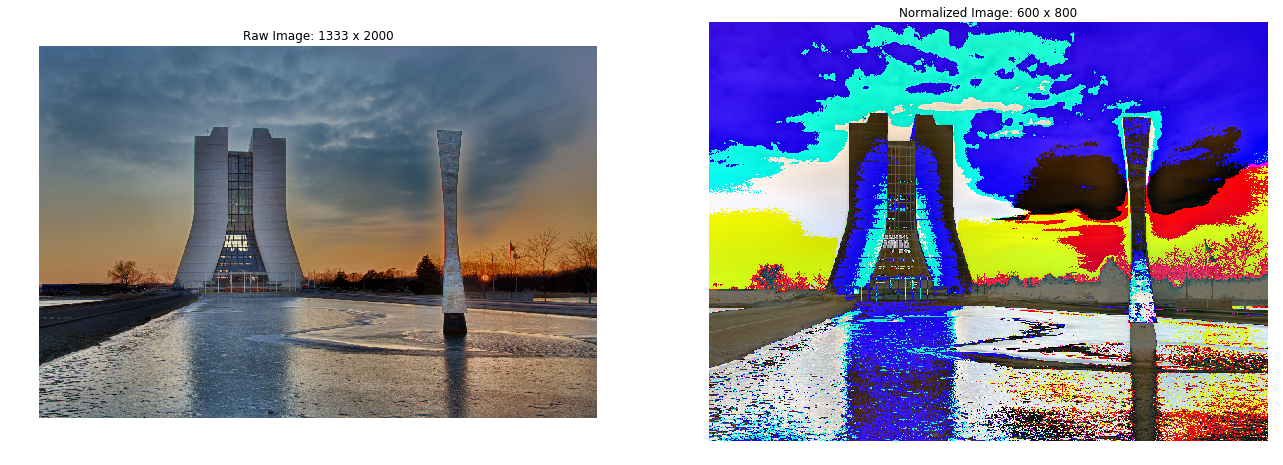

In [11]:
raw_source = plt.imread(source)
cropped_source = crop_by_aspectr(raw_source)
resized_source = resizer(cropped_source)

path = out_dir + '/' + source_root + '_resized.png'
scipy.misc.imsave(path, resized_source.astype('uint8'))
    
normed_source = tensorfy_and_normalize(resized_source)
show_img_pair(raw_source, normed_source)

As a sanity check, let's be sure that if we add the `VGG_MEAN_VALUES` back, we get the image we expect:

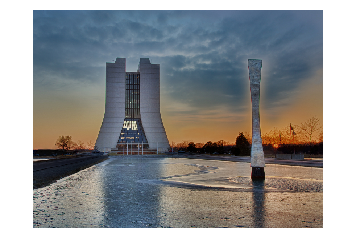

In [12]:
imshow_clean((normed_source + VGG_MEAN_VALUES)[0].astype('uint8'))

Now, let's do the same for the style image:

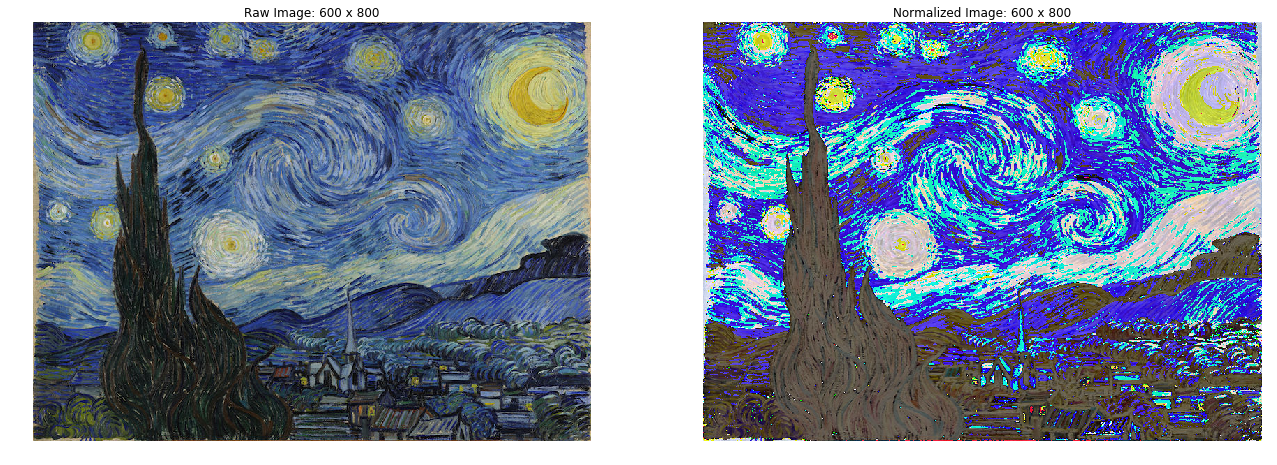

In [13]:
raw_style = plt.imread(style)
cropped_style = crop_by_aspectr(raw_style)
resized_style = resizer(cropped_style)

path = out_dir + '/' + style_root + '_resized.png'
scipy.misc.imsave(path, resized_style.astype('uint8'))

normed_style = tensorfy_and_normalize(resized_style)
show_img_pair(raw_style, normed_style)

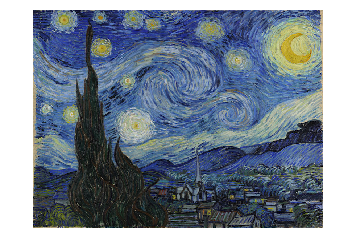

In [14]:
imshow_clean((normed_style + VGG_MEAN_VALUES)[0].astype('uint8'))

Let's rename the images for convenience / simplicity...

In [15]:
source_img = normed_source
style_img = normed_style

## Network Definition

We use a high level in the network for content and multuple levels for style. We could switch to a different (probably higher) level for the content if we wished. We can also edit the style list to get different results... perhaps experiment with these?

In [16]:
# choice in the paper
# CONTENT_LAYERS = [('conv4_2', 1.)]   
# STYLE_LAYERS = [('conv1_1', 1.), ('conv2_1', 1.), ('conv3_1', 1.), ('conv4_1', 1.), ('conv5_1', 1.)]

# experiment 1
# CONTENT_LAYERS = [('conv5_1', 1.)]
# STYLE_LAYERS = [('conv1_1', 1.), ('conv2_1', 1.), ('conv3_1', 1.)]

# experiment 2
CONTENT_LAYERS = [('conv5_1', 1.)]
STYLE_LAYERS = [('conv1_1', 0.5), ('conv2_1', 1.), ('conv3_1', 1.5), ('conv4_1', 2.)]

Now, let's define a utility function for building layers and chaining them together:

In [17]:
def build_net(ntype, nin, rwb=None):
    """
    utility function for building network layers
    * ntype == network layer type (string, 'conv' or 'pool')
    * nin == network input layer (the object itself)
    * rwb == weights and biases
    """
    # `strides` basically describe how far the kernel steps in each tensor dimension
    # `ksize` describes the size of the pooling region
    # If we use `SAME` padding, the filter is allowed to go off the edge by half the filter size on each side,
    # so we would expect an unchanged image size with stride=1 and a (1/2)x(1/2) for stride=2.
    if ntype == 'conv':
        return tf.nn.relu(tf.nn.conv2d(nin, rwb[0], strides=[1, 1, 1, 1], padding='SAME') + rwb[1])
    elif ntype == 'pool':
        return tf.nn.avg_pool(nin, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

### Detour on kernels, strides, and padding

`ksize` tells us about kernel size (4-tensor), and strides tells us how far we move the the kernel with each "step" when mapping it across the image. Padding is explained in the TF [documentation for convolution](https://www.tensorflow.org/api_docs/python/nn/convolution#convolution). 

Let's take a detour and demonstrate it with the pooling operation:

In [18]:
# super-simple "graph" to demonstrate pooling
# X shape of None x 6 x 6 x 1 -> any number of 6x6 tensors that are "1-deep" (e.g., grayscale)
X = tf.placeholder(tf.float32, shape=(None, 6, 6, 1), name='X')
Y_same = tf.nn.avg_pool(X, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
Y_valid = tf.nn.avg_pool(X, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

TensorFlow separates graph definition and computation into two steps - we must execute operations within a _Session_.

In [19]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

We need to pass a tensor with actual data into our "graph" to see how it works.

In [20]:
X_vals = np.arange(6*6).reshape(1, 6, 6, 1)
print(X_vals)

[[[[ 0]
   [ 1]
   [ 2]
   [ 3]
   [ 4]
   [ 5]]

  [[ 6]
   [ 7]
   [ 8]
   [ 9]
   [10]
   [11]]

  [[12]
   [13]
   [14]
   [15]
   [16]
   [17]]

  [[18]
   [19]
   [20]
   [21]
   [22]
   [23]]

  [[24]
   [25]
   [26]
   [27]
   [28]
   [29]]

  [[30]
   [31]
   [32]
   [33]
   [34]
   [35]]]]


To get a value we must run the computation inside the `Session` we created earlier. `feed_dict` tells TF what values to plug into the placeholder we used to start the graph:

In [21]:
Y_same_vals = sess.run(Y_same, feed_dict={X: X_vals})
print(Y_same_vals.shape)
print(Y_same_vals)

(1, 3, 3, 1)
[[[[  3.5]
   [  5.5]
   [  7.5]]

  [[ 15.5]
   [ 17.5]
   [ 19.5]]

  [[ 27.5]
   [ 29.5]
   [ 31.5]]]]


In [22]:
Y_valid_vals = sess.run(Y_valid, feed_dict={X: X_vals})
print(Y_valid_vals.shape)
print(Y_valid_vals)

(1, 3, 3, 1)
[[[[  3.5]
   [  5.5]
   [  7.5]]

  [[ 15.5]
   [ 17.5]
   [ 19.5]]

  [[ 27.5]
   [ 29.5]
   [ 31.5]]]]


In this case, the tensors came out the same because the kernel and stride sizes conspired with the image size to keep the filter mapping "inside" the tensor. What does this mapping look like (with a lazy figure)?

<img src='./pooling_examp.png'>

Let's try again with a different stride to see if we can get a better sense for the difference.

First, let's 'reset' the graph, just to keep things simple:

In [23]:
ops.reset_default_graph()

Let's look at a different stride to see if the pooling ops behave differently:

In [24]:
X = tf.placeholder(tf.float32, shape=(None, 6, 6, 1), name='X')
Y_same = tf.nn.avg_pool(X, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='SAME')
Y_valid = tf.nn.avg_pool(X, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='VALID')

In [25]:
# we are using the default graph, so we have to re-initialize
sess = tf.Session()
sess.run(tf.initialize_all_variables())

In [26]:
Y_same_vals = sess.run(Y_same, feed_dict={X: X_vals})
print(Y_same_vals.shape)
print(Y_same_vals)

(1, 6, 6, 1)
[[[[  3.5]
   [  4.5]
   [  5.5]
   [  6.5]
   [  7.5]
   [  8. ]]

  [[  9.5]
   [ 10.5]
   [ 11.5]
   [ 12.5]
   [ 13.5]
   [ 14. ]]

  [[ 15.5]
   [ 16.5]
   [ 17.5]
   [ 18.5]
   [ 19.5]
   [ 20. ]]

  [[ 21.5]
   [ 22.5]
   [ 23.5]
   [ 24.5]
   [ 25.5]
   [ 26. ]]

  [[ 27.5]
   [ 28.5]
   [ 29.5]
   [ 30.5]
   [ 31.5]
   [ 32. ]]

  [[ 30.5]
   [ 31.5]
   [ 32.5]
   [ 33.5]
   [ 34.5]
   [ 35. ]]]]


So here, `SAME` goes "off the edge" on the right to keep the overall tensor the same size...

In [27]:
Y_valid_vals = sess.run(Y_valid, feed_dict={X: X_vals})
print(Y_valid_vals.shape)
print(Y_valid_vals)

(1, 5, 5, 1)
[[[[  3.5]
   [  4.5]
   [  5.5]
   [  6.5]
   [  7.5]]

  [[  9.5]
   [ 10.5]
   [ 11.5]
   [ 12.5]
   [ 13.5]]

  [[ 15.5]
   [ 16.5]
   [ 17.5]
   [ 18.5]
   [ 19.5]]

  [[ 21.5]
   [ 22.5]
   [ 23.5]
   [ 24.5]
   [ 25.5]]

  [[ 27.5]
   [ 28.5]
   [ 29.5]
   [ 30.5]
   [ 31.5]]]]


... but `VALID` requires the kernel to stay entirely in-bounds. This means the output tensor must shrink.

Ok, with that demo over, let's reset the graph. Before we do, we can inspect it:

In [28]:
[op.name for op in tf.get_default_graph().get_operations()]

['X', 'AvgPool', 'AvgPool_1', 'init']

In [29]:
ops.reset_default_graph()

In [30]:
[op.name for op in tf.get_default_graph().get_operations()]

[]

### VGG

Now, let's define a funciton we can use to extract the model parameters from the pre-trained VGG file we downloaded:

In [31]:
def get_weight_bias(vgg_layers, i):
    """
    utility function to get weights and bias values from the layers of our pre-built vgg19 model;
    we set the weights as `constant` to indicate they should not be trainable.
    """
    weights = vgg_layers[i][0][0][0][0][0]
    weights = tf.constant(weights)
    bias = vgg_layers[i][0][0][0][0][1]
    bias = tf.constant(np.reshape(bias, (bias.size)))
    return weights, bias

And, now for the network:

In [32]:
def build_vgg19(path):
    """
    build the VGG DNN
    """
    net = {}
    vgg_rawnet = scipy.io.loadmat(path)
    vgg_layers = vgg_rawnet['layers'][0]
    net['input'] = tf.Variable(np.zeros((1, IMAGE_H, IMAGE_W, 3)).astype('float32'))
    net['conv1_1'] = build_net('conv', net['input'], get_weight_bias(vgg_layers, 0))
    net['conv1_2'] = build_net('conv', net['conv1_1'], get_weight_bias(vgg_layers, 2))
    net['pool1'] = build_net('pool', net['conv1_2'])
    net['conv2_1'] = build_net('conv', net['pool1'], get_weight_bias(vgg_layers, 5))
    net['conv2_2'] = build_net('conv', net['conv2_1'], get_weight_bias(vgg_layers, 7))
    net['pool2'] = build_net('pool', net['conv2_2'])
    net['conv3_1'] = build_net('conv', net['pool2'], get_weight_bias(vgg_layers, 10))
    net['conv3_2'] = build_net('conv', net['conv3_1'], get_weight_bias(vgg_layers, 12))
    net['conv3_3'] = build_net('conv', net['conv3_2'], get_weight_bias(vgg_layers, 14))
    net['conv3_4'] = build_net('conv', net['conv3_3'], get_weight_bias(vgg_layers, 16))
    net['pool3'] = build_net('pool', net['conv3_4'])
    net['conv4_1'] = build_net('conv', net['pool3'], get_weight_bias(vgg_layers, 19))
    net['conv4_2'] = build_net('conv', net['conv4_1'], get_weight_bias(vgg_layers, 21))
    net['conv4_3'] = build_net('conv', net['conv4_2'], get_weight_bias(vgg_layers, 23))
    net['conv4_4'] = build_net('conv', net['conv4_3'], get_weight_bias(vgg_layers, 25))
    net['pool4'] = build_net('pool', net['conv4_4'])
    net['conv5_1'] = build_net('conv', net['pool4'], get_weight_bias(vgg_layers, 28))
    net['conv5_2'] = build_net('conv', net['conv5_1'], get_weight_bias(vgg_layers, 30))
    net['conv5_3'] = build_net('conv', net['conv5_2'], get_weight_bias(vgg_layers, 32))
    net['conv5_4'] = build_net('conv', net['conv5_3'], get_weight_bias(vgg_layers, 34))
    net['pool5'] = build_net('pool', net['conv5_4'])
    return net

Now we may compute loss functions.

In order to visualize the encoded image information, we use gradient descent on the pixel values in a white-noise image to find a new image that matches the in-network responses of the original image. So, for the image content we define the error as the squared difference between the feature representations of the 'source' and 'target' images: 

In [33]:
def build_content_loss(p, x):
    """
    here, p has shape (batch, h, w, n-channels)
    
    * p is an evaluated TF tensor or a ndarray
    * x is a TF placeholder
    """
    M = p.shape[1] * p.shape[2]   # h x w
    N = p.shape[3]                # n-channels
    loss = (1. / (2 * N**0.5 * M**0.5)) * tf.reduce_sum(tf.pow((x - p), 2))
    return loss

**Note:** the paper defines the content loss slightly differently (no 'normalizing' factor that is a function of image size and depth). However, we include one here to scale down the absolute value of the loss. 

In order to define the style loss, we need to first define computations for the Gram matrix, $G^l \in \mathcal{R}^{N_l \times N_l}$, with $N_l$ equal to the number of filter maps in layer $l$, and $G^{l}_{ij}$ equal to the inner product between the vectorized feature maps $i$ and $j$ in layer $l$,

\begin{equation}
G^{l}_{ij} = \sum_k F^{l}_{ik} F^{l}_{jk}
\end{equation}

We define two versions of the matrix (computing function). First, we define a "TensorFlow version," that expects TF variables that constructs a graph element. Second, we define a "NumPy version" that expects NumPy arrays and computes a fixed value (based on the initial network weights).

In [34]:
def gram_matrix(x, area, depth):
    """
    input/evaluate with TF tensors
    
    here we take a tensor of shape (1, h, w, n) and reshape it to (h * w, n),
    and then compute the inner product of the new tensor with itself
    """
    x1 = tf.reshape(x, (area, depth))
    g = tf.matmul(tf.transpose(x1), x1)
    return g

In [35]:
def gram_matrix_val(x, area, depth):
    """
    numpy version of the `gram_matrix` method (may be evaluated outside a TF `Session`)
    
    here we take a ndarray of shape (1, h, w, n) and reshape it to (h * w, n),
    and then compute the inner product of the new ndarray with itself
    """
    x1 = x.reshape(area, depth)
    g = np.dot(x1.T, x1)
    return g

In [36]:
def build_style_loss(a, x):
    """
    here, a has shape (batch, h, w, n-channels)
    
    * a is an evaluated TF tensor or a ndarray
    * x is a TF placeholder
    """
    M = a.shape[1] * a.shape[2]    # h x w
    N = a.shape[3]                 # n-channels
    A = gram_matrix_val(a, M, N)   
    G = gram_matrix(x, M, N)
    loss = (1. / (4 * N**2 * M**2)) * tf.reduce_sum(tf.pow((G - A), 2))
    return loss

Now, with helper functions set, let's perform the style transfer.

In [37]:
net = build_vgg19(vggmodelfile)

In [38]:
[op.name for op in tf.get_default_graph().get_operations()]

['Variable/initial_value',
 'Variable',
 'Variable/Assign',
 'Variable/read',
 'Const',
 'Const_1',
 'Conv2D',
 'add',
 'Relu',
 'Const_2',
 'Const_3',
 'Conv2D_1',
 'add_1',
 'Relu_1',
 'AvgPool',
 'Const_4',
 'Const_5',
 'Conv2D_2',
 'add_2',
 'Relu_2',
 'Const_6',
 'Const_7',
 'Conv2D_3',
 'add_3',
 'Relu_3',
 'AvgPool_1',
 'Const_8',
 'Const_9',
 'Conv2D_4',
 'add_4',
 'Relu_4',
 'Const_10',
 'Const_11',
 'Conv2D_5',
 'add_5',
 'Relu_5',
 'Const_12',
 'Const_13',
 'Conv2D_6',
 'add_6',
 'Relu_6',
 'Const_14',
 'Const_15',
 'Conv2D_7',
 'add_7',
 'Relu_7',
 'AvgPool_2',
 'Const_16',
 'Const_17',
 'Conv2D_8',
 'add_8',
 'Relu_8',
 'Const_18',
 'Const_19',
 'Conv2D_9',
 'add_9',
 'Relu_9',
 'Const_20',
 'Const_21',
 'Conv2D_10',
 'add_10',
 'Relu_10',
 'Const_22',
 'Const_23',
 'Conv2D_11',
 'add_11',
 'Relu_11',
 'AvgPool_3',
 'Const_24',
 'Const_25',
 'Conv2D_12',
 'add_12',
 'Relu_12',
 'Const_26',
 'Const_27',
 'Conv2D_13',
 'add_13',
 'Relu_13',
 'Const_28',
 'Const_29',
 'Conv2D

In [39]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

We define a white noise image to use as a starting point (we will actually cheat and 'mix' some of the starting image into this one to help the network out): 

In [40]:
noise_img = np.random.uniform(-20, 20, (1, IMAGE_H, IMAGE_W, 3)).astype('float32')

Now, we build the cost function for the source image's contributon to the total cost. We will map our loss function over the set of layers we want to use (just one, typically, for the content). We want to build a TF 'function' that operates on a given input image, but we want to go ahead and compute the values for the real target source image. Therefore, we will `run()` the network _on_ the source to actually define the function:

In [41]:
print(CONTENT_LAYERS)
sess.run([net['input'].assign(source_img)])
cost_source = sum(
    map(lambda l,: l[1] * build_content_loss(sess.run(net[l[0]]), net[l[0]]), CONTENT_LAYERS)
)

[('conv5_1', 1.0)]


In [42]:
print(STYLE_LAYERS)
sess.run([net['input'].assign(style_img)])
cost_style = sum(
    map(lambda l,: l[1] * build_style_loss(sess.run(net[l[0]]), net[l[0]]), STYLE_LAYERS)
)

[('conv1_1', 0.5), ('conv2_1', 1.0), ('conv3_1', 1.5), ('conv4_1', 2.0)]


In [43]:
STYLE_STRENGTH = 500
cost_total = cost_source + STYLE_STRENGTH * cost_style
optimizer = tf.train.AdamOptimizer(learning_rate=2.0)
train = optimizer.minimize(cost_total)

In [44]:
print(np.min(1. * source_img), np.max(1. * source_img))

-123.0 125.941768229


noise image :  -20.0 20.0
source image:  -123.0 125.941768229
src+vgg img :  0.0 246.032977604
combo image :  -50.6598009109 49.7044646201
cmb+vgg img :  58.824933815 171.035785802


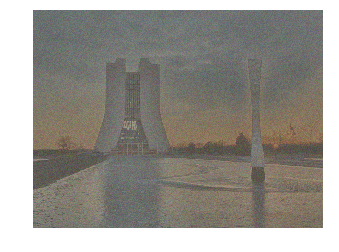

In [45]:
INI_NOISE_RATIO = 0.7
initial_img = INI_NOISE_RATIO * noise_img + (1. - INI_NOISE_RATIO) * source_img
print('noise image : ', np.min(noise_img), np.max(noise_img))
print('source image: ', np.min(source_img), np.max(source_img))
print('src+vgg img : ', np.min(source_img + VGG_MEAN_VALUES), np.max(source_img + VGG_MEAN_VALUES))
print('combo image : ', np.min(initial_img[0]), np.max(initial_img[0]))
print('cmb+vgg img : ', np.min((initial_img + VGG_MEAN_VALUES)[0]), np.max((initial_img + VGG_MEAN_VALUES)[0]))
imshow_clean((initial_img + VGG_MEAN_VALUES)[0].astype('uint8'))

path = out_dir + '/initial.png'
scipy.misc.imsave(path, np.clip((initial_img + VGG_MEAN_VALUES)[0], 0, 255).astype('uint8'))

In [46]:
sess.run(tf.initialize_all_variables())
sess.run(net['input'].assign(initial_img))

array([[[[-19.98554993, -10.05685043,   7.64273834],
         [-14.85352325, -14.57948303,   5.02478361],
         [ -9.91827393,  -1.30161011,  19.17552567],
         ..., 
         [ -7.86698198,  11.13206005,  22.04566956],
         [-10.12844467, -12.81865025,  24.14760971],
         [ -5.52670574,   1.13656616,  -0.75316072]],

        [[-19.86244965,  -0.63559407,  -1.50746179],
         [-29.5409317 , -15.21260929,  23.31343079],
         [-26.98409843, -10.9077158 ,   4.45820379],
         ..., 
         [ -7.9533062 ,  -5.16355753,   5.71547222],
         [-22.54921532,   3.82208252,   7.02165031],
         [-17.54363632,  10.27162552,  -0.92607898]],

        [[-20.73846817,  -9.83894253,  20.93431473],
         [ -6.26268244,  -3.9100771 ,  16.2124939 ],
         [-29.61398888,   4.15496969,   7.29447508],
         ..., 
         [ -1.49543691,  -2.51054478,   6.37512493],
         [-10.93195248,  -8.84562397,  -1.6101191 ],
         [-17.52678299,   5.96810675,   9.02319527

In [47]:
for i in range(500):
    sess.run(train)
    result_image = sess.run(net['input'])
    print(i, sess.run(cost_total))
    if (i + 1) % 20 == 0:
        path = out_dir + '/styled_%04d.png' % i
        scipy.misc.imsave(path, np.clip((result_image + VGG_MEAN_VALUES)[0], 0, 255).astype('uint8'))

0 5.63721e+11
1 4.99677e+11
2 4.38109e+11
3 3.81421e+11
4 3.30775e+11
5 2.86551e+11
6 2.48925e+11
7 2.17737e+11
8 1.92185e+11
9 1.71352e+11
10 1.54472e+11
11 1.40862e+11
12 1.2973e+11
13 1.20212e+11
14 1.11513e+11
15 1.03113e+11
16 9.48095e+10
17 8.6738e+10
18 7.91269e+10
19 7.22224e+10
20 6.61439e+10
21 6.08712e+10
22 5.63004e+10
23 5.22696e+10
24 4.86328e+10
25 4.52928e+10
26 4.21876e+10
27 3.9287e+10
28 3.65992e+10
29 3.41354e+10
30 3.18944e+10
31 2.98601e+10
32 2.80118e+10
33 2.63256e+10
34 2.47814e+10
35 2.33618e+10
36 2.20584e+10
37 2.08638e+10
38 1.97721e+10
39 1.87824e+10
40 1.78884e+10
41 1.70786e+10
42 1.63408e+10
43 1.56645e+10
44 1.50436e+10
45 1.44737e+10
46 1.39509e+10
47 1.34712e+10
48 1.30276e+10
49 1.26136e+10
50 1.22237e+10
51 1.18546e+10
52 1.15063e+10
53 1.11784e+10
54 1.0871e+10
55 1.05825e+10
56 1.03106e+10
57 1.00528e+10
58 9.8073e+09
59 9.5728e+09
60 9.34854e+09
61 9.13422e+09
62 8.93016e+09
63 8.73639e+09
64 8.55245e+09
65 8.37731e+09
66 8.2099e+09
67 8.04921e+

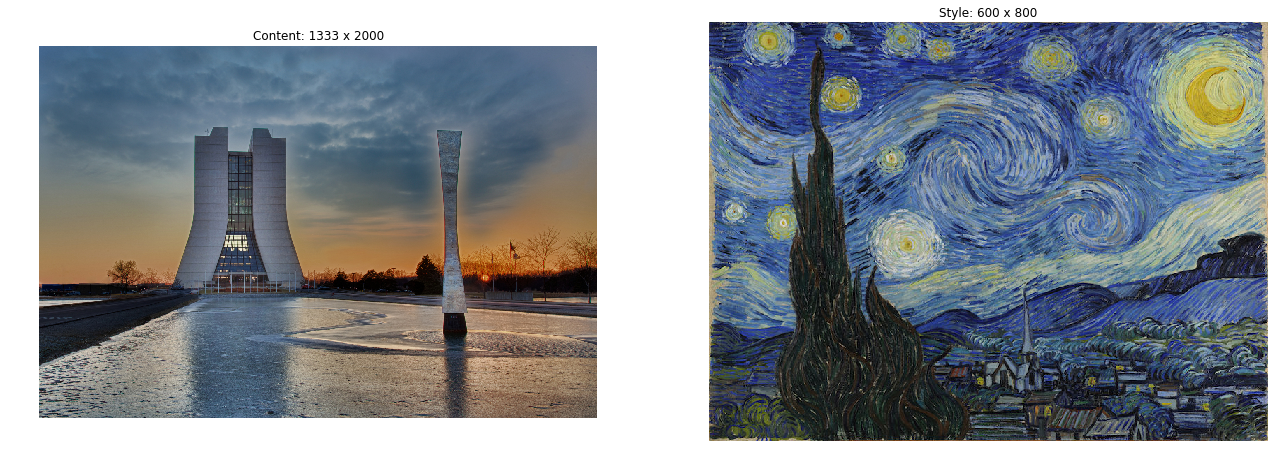

In [48]:
show_img_pair(raw=raw_source, normed=raw_style,  
              raw_title='Content', normed_title='Style', interpolation=None,
              raw_type='uint8', normed_type='uint8')

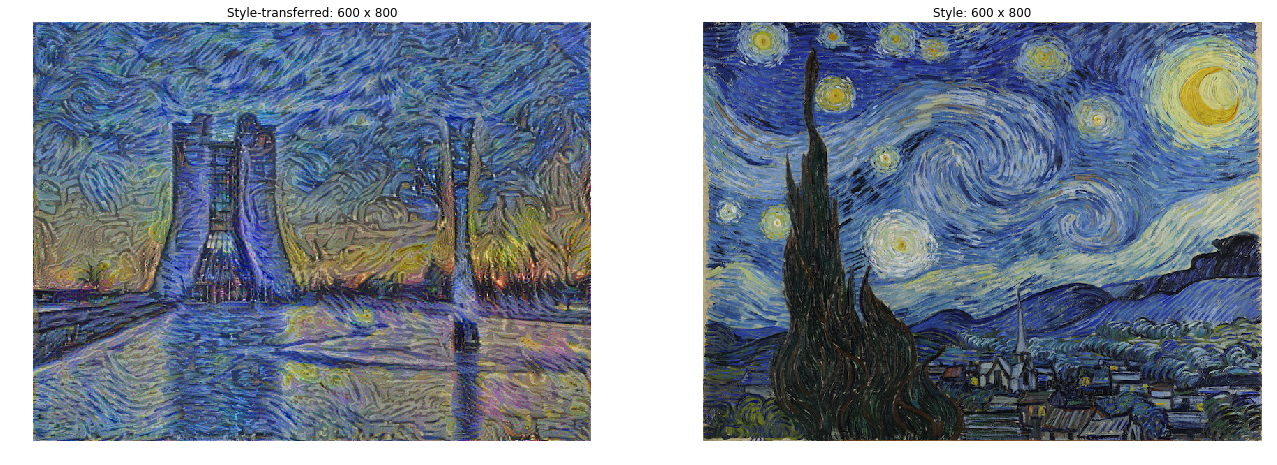

In [49]:
show_img_pair(raw=np.clip((result_image + VGG_MEAN_VALUES)[0], 0, 255), normed=raw_style,  
              raw_title='Style-transferred', normed_title='Style', interpolation=None,
              raw_type='uint8', normed_type='uint8')